In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

%matplotlib inline

## Helper function and constants

In [2]:
LEADS = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
DIAGS = [
    "1st degree AV block (1dAVb)",
    "right bundle branch block (RBBB)",
    "left bundle branch block (LBBB)",
    "sinus bradycardia (SB)",
    "atrial fibrillation (AF)",
    "sinus tachycardia (ST)",
]

## Extract data

In [3]:
import xml.etree.ElementTree as ET


def get_diagnosis(filename: str) -> str:
    root = ET.parse(filename).getroot()
    node = root[6]
    
    diagnosis = 'Diagnosis:\n'
    for i in node:
        if i.tag == "DiagnosisStatement":
            for j in i:
                if j.tag == "StmtText":
                    diagnosis += '\n' + j.text
    return diagnosis

In [4]:
import os
files = []
with open('data/valid_muse.txt') as file_list:
    for line in file_list:
        files.append(line.strip().split('.xml')[0])

In [5]:
ecg = []
diagnosis = []
for file in tqdm(files):
    data = pd.read_csv('data/csv/' + file.split('/')[-1] + '.csv').drop(columns=["Unnamed: 12", "Unnamed: 13", "V4R"], errors='ignore')
    diag = get_diagnosis(os.path.join('data', file + '.xml'))
    ecg.append(data)
    diagnosis.append(diag)
    # print(file, '\n', diagnosis, '\n', '--------------------------', '\n')
ecg = np.array(ecg)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286/2286 [00:15<00:00, 144.75it/s]


In [6]:
print(diagnosis[1001])

Diagnosis:

Fibrillation auriculaire
Anomalie non spécifique du segment S-T et de l'onde T
, imprégnation digitalique probable
QT allongé
ECG anormal
Lors dâune comparaison à lâECG de
27-nov-2018 09:59,
Aucun changement significatif constaté


## Neurokit


In [7]:
import neurokit2 as nk
import time

In [301]:
def segment(ecg, rpeaks, before:int=250, after:int=250, sampling_rate:int=500, show:bool=False) -> pd.DataFrame:
    segmented = []
    for i, peak in enumerate(rpeaks):
        start = peak - before
        end = peak + after
        if start >= 0 and end <= ecg.shape[-1]:
            segmented.append(ecg[start:end])
    segmented = np.array(segmented)
    if show:
        plt.figure()
        X = np.arange(before+after)
        X = (X - before) / sampling_rate
        for seg in segmented:
            plt.plot(X, seg)
        plt.title('Segmented beats')
        plt.xlabel('time (s)')
        plt.ylabel('signal')
        plt.xlim(-before / sampling_rate, after / sampling_rate)
        plt.grid()
        plt.show()
    return segmented

In [302]:
def clean_and_segment(ecg, show:bool=False, use_raw_if_error:bool=False, clean=None):
    SAMPLE_RATE = 500
    ecg = nk.ecg_invert(ecg, sampling_rate=SAMPLE_RATE)[0]
    rpeaks = None
    if clean is None:
        clean = []
    for method in clean:
        try:
            cleaned = nk.ecg_clean(ecg, sampling_rate=SAMPLE_RATE, method=method)
            rpeaks = nk.ecg_peaks(cleaned, sampling_rate=SAMPLE_RATE, method='neurokit')[1]['ECG_R_Peaks']
            assert len(rpeaks) > 0
        except Exception as e:
            continue
        break
    else:
        cleaned = ecg
        rpeaks = nk.ecg_peaks(cleaned, sampling_rate=SAMPLE_RATE, method='neurokit')[1]['ECG_R_Peaks']
    segmented = segment(cleaned, rpeaks, show=show)
    return cleaned, segmented

In [303]:
def median_beat(ecg):
    cleaned, segmented = clean_and_segment(ecg)
    # segmented_df = nk.epochs.epochs_to_df(segmented)
    # drop = ['1', str(len(segmented_df['Label'].unique()))]
    # segmented_df = segmented_df[(segmented_df['Label'] != drop[0]) & (segmented_df['Label'] != drop[1])]
    # med = segmented_df.groupby('Time').median()['Signal']
    # print(segmented.shape)
    med = np.median(segmented, axis=0)
    # print(med.shape)
        
    return med

In [310]:
ningbo = np.load('ecgxai/Ningbo/JS/S2/20/JS20301.npy')

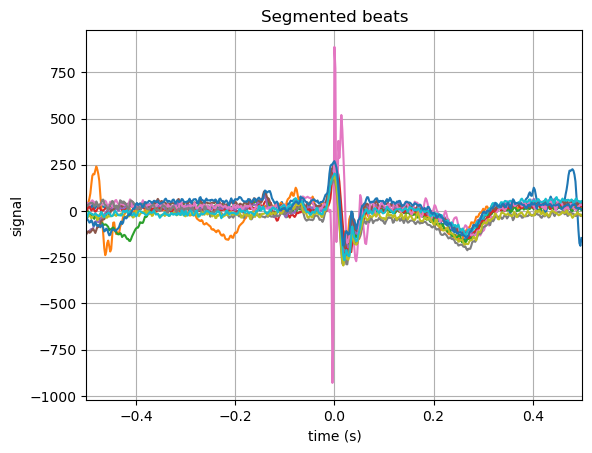

In [311]:
cleaned, segmented = clean_and_segment(ningbo[6], show=True, clean=['engzee'])

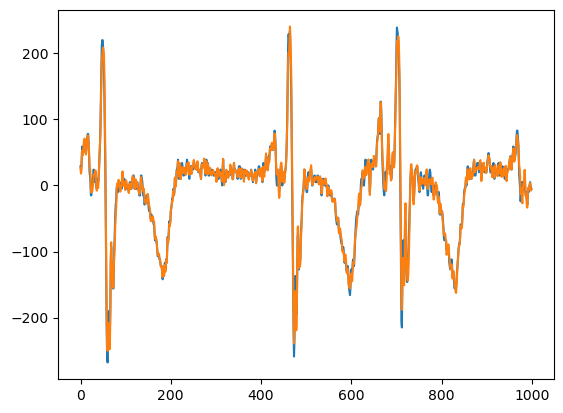

In [312]:
plt.plot(ningbo[6][:1000])
plt.plot(cleaned[:1000])

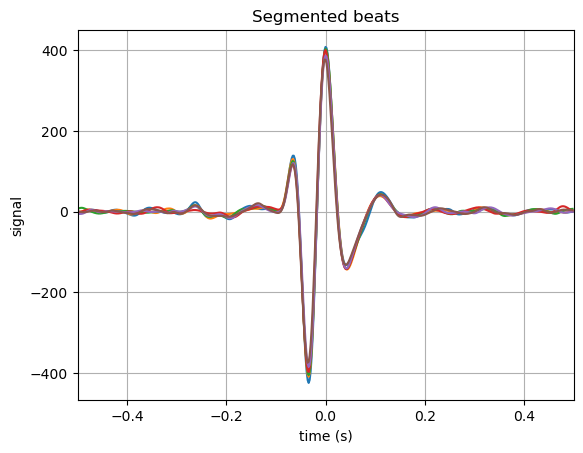

array([[-5.28594711, -5.16665558, -4.81264515, ..., -0.90092381,
        -0.50216036, -0.11270223],
       [-0.95893752, -0.78459866, -0.51587788, ...,  1.39499879,
         2.31313206,  3.15879037],
       [ 6.69702365,  7.7997    ,  8.66746503, ...,  6.42284595,
         6.65563726,  6.809494  ],
       [-2.17318067, -1.8550454 , -1.37348055, ...,  4.1709407 ,
         2.47892797,  0.87779536],
       [-4.85322345, -5.34341143, -5.5927726 , ..., -0.48327506,
        -0.1805884 ,  0.02845633],
       [ 1.02183384,  0.51100193, -0.04786157, ...,  3.6897648 ,
         3.53049683,  3.29237537]])

In [247]:
cleaned, segmented = clean_and_segment(ecg[324,:,1], show=True)
segmented

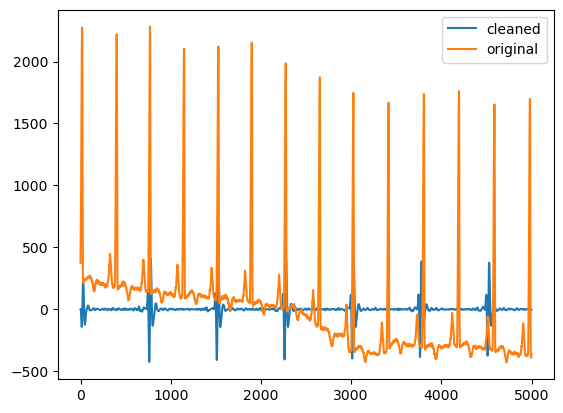

In [248]:
plt.plot(cleaned, label='cleaned')
plt.plot(nk.ecg_invert(ecg[112,:,1])[0], label='original')
plt.legend()

In [244]:
segmented.shape

(6, 500)

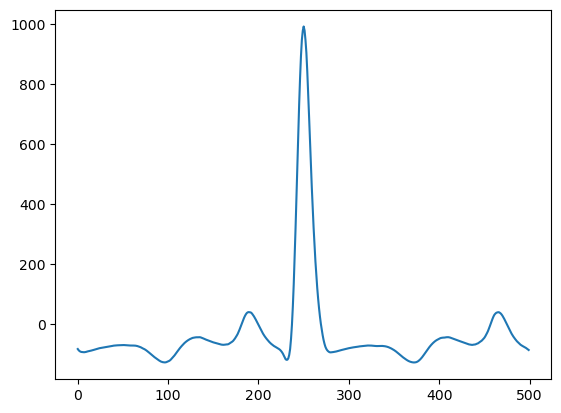

In [170]:
plt.plot(np.median(segmented, axis=0))